In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 20
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-woman with a dragon-head who can make a huge difference. I can help you find the dragon-head you're looking for!

This blog is a part of the Dragon-Women’s Survival Guide series. I also write about the dragon-head’s journey from dragon-man to dragon-woman. Please visit the Dragon-Women’s Survival Guide page for more information.

About the Dragon-Women

Dragon-Women are my first and only female-driven dragon-woman. My goal is to make sure I can provide you with the


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>n "I knew I could do without him, at any rate."<|endoftext|><d><scn>emeraroom<msg>Em "My approach has been called {i}daring{/i} or {i}brave{/i} just as much as it has been derided by others who don't like what I am doing."<|endoftext|><p><msg>c "Meet with Zhong"<d><scn>bare<msg>Zh "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|><
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


>Ad "Really?"<|endoftext|><p><msg>c "Visit Reza"<d><scn>park3<msg>Rz "Hey [player_name]!"<|endoftext|><d><scn>loremapt<msg>Ip "Evidently, she thinks otherwise."<|endoftext|><p><msg>c "Fight Ipsum"<d><scn>loremapt<msg>m "I didn't hesitate and kicked Ipsum right in the stomach"<|endoftext|><d><scn>cafe<msg>An "Like what?"<|endoftext|><d><scn>park3<msg
>Em "... immediately."<|endoftext|><d><scn>black<msg>Lo "My species is perfectly suited for the job, so they were glad to have me on board."<|endoftext|><p><msg>c "Otomo Izumi"<|endoftext|><p><msg>c "Okay, now for the technique..."<d><scn>beach<msg>m "She was holding the stone in the claws at the edge of her wing. I tried to guide her by pulling her wing back like I would an arm, but it became clear to me that it lacked a lot of maneuverability an arm would have


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
21,4.162500
42,2.575100
63,2.004400
84,1.817900
105,1.678200
126,1.489400
147,1.487500
168,1.413700
189,1.328500
210,1.376600


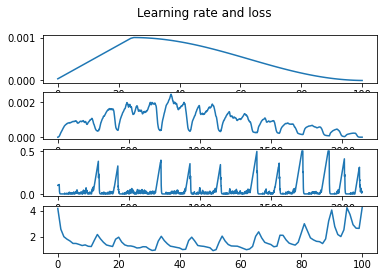

In [9]:
fig, axs = plt.subplots(4)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['mix_rate'])
axs[3].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1.17 MiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTor

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [ ]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm
PyTorch: In my dreams, I'm a dragonfly! I'm a dragonfly!

My dreams are always about my dragons.

They are always about me.

They are always about me.

I've had to keep them to myself.

I've had to keep them to myself.

They are always about me.

They are always about me.

They are always about me.

I'm afraid of them.

I'm afraid of them.

I'm afraid of them.

I'm afraid of them.

I'm afraid of them.
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [ ]:
test_regular_sampler()

**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [ ]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

# Sampling test

This is gonna be interesting!

In [ ]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-" * 10)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

# RP test
Testing out the injected roleplay actions

In [ ]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'[Pytorch] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print(f'[ONNX] {rp} -> {onnx_model_manager.say("", rp, do_sample = True)}')
    print("-" * 10)